**1. Import Packages and relevant files**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
df = pd.read_csv('/content/drive/MyDrive/hdb-price-with-features-2014to2023.csv')
cpi = pd.read_csv('/content/drive/MyDrive/CPI 2004 to 2023.csv')

df['month'] = pd.to_datetime(df['month'], format='%m/%d/%Y')
df['year'] = df['month'].dt.year

cpi['month'] = pd.to_datetime(cpi['month'], format='%m/%d/%Y')

In [94]:
df.head()

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,mall_count_within_1km,mall_list_within_1km,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,distance_to_cbd_km,matured,year
0,0,2023-03-01,BISHAN,4 ROOM,289,BISHAN ST 24,22 TO 24,103.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2023
1,1,2022-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,22 TO 24,102.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022
2,2,2022-11-01,BISHAN,4 ROOM,289,BISHAN ST 24,16 TO 18,102.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022
3,3,2022-06-01,BISHAN,5 ROOM,289,BISHAN ST 24,07 TO 09,121.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022
4,4,2021-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,07 TO 09,102.0,Premium Apartment,1998,...,1,['Junction 8'],0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2021


In [95]:
cpi.head()

,month,CPI
0,2004-01-01,75.741
1,2004-02-01,76.613
2,2004-03-01,76.051
3,2004-04-01,76.564
4,2004-05-01,76.747


**2. Normalize Price with CPI (Base Year 2019)**

In [99]:
df = df.drop(df.columns[0], axis=1)
df = pd.merge(df, cpi, on='month')
df['normalized_price'] = (df['resale_price'] / df['CPI']) * 100
df = df.drop(['resale_price'], axis=1)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,school_shortest_dist,school_shortest_dist_name,good_sch_count_within_1km,good_sch_list_within_1km,good_sch_score,distance_to_cbd_km,matured,year,CPI,normalized_price
0,2022-12-01,BISHAN,4 ROOM,289,BISHAN ST 24,22 TO 24,102.0,Premium Apartment,1998,74.583333,...,0.214393,Catholic High School,1,['Catholic High School'],3,7.635584,1,2022,111.186,764484.737287
1,2022-12-01,HOUGANG,5 ROOM,984B,BUANGKOK LINK,07 TO 09,110.0,Improved,2004,80.250000,...,0.521532,Hougang Primary School,0,[],0,10.892938,0,2022,111.186,528843.559441
2,2022-12-01,HOUGANG,5 ROOM,156,HOUGANG ST 11,07 TO 09,126.0,Improved,1984,61.166667,...,0.687055,Methodist Girls' School (Primary),2,"[""Methodist Girls' School (Primary)"", ""Paya Le...",2,7.782195,0,2022,111.186,593599.913658
3,2022-12-01,HOUGANG,4 ROOM,376A,HOUGANG ST 32,07 TO 09,92.0,Model A,2016,92.333333,...,0.389245,Holy Innocents' Primary School,1,"[""Holy Innocents' Primary School""]",2,9.557265,0,2022,111.186,509056.895652
4,2022-12-01,GEYLANG,4 ROOM,2A,GEYLANG SERAI,16 TO 18,93.0,Model A,2011,88.083333,...,0.800717,Haig Girls' School,0,[],0,6.040011,1,2022,111.186,715018.077816


In [100]:
df.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**3. Feature Selection/Engineering**

In [ ]:
df = df.drop(['block', 'street_name', 'lease_commence_date', 'address', 'latitude', 'longitude', 'mrt_list_within_1km', 'mall_list_within_1km', 'good_sch_list_within_1km', 'shortest_dist_mrt_name', 'shortest_dist_mall_name', 'school_shortest_dist_name','month'], axis=1)
#'block', 'street_name' ,'address' ,'latitude' ,'longitude' are features used to generate more meaningful data(ie nearest mall, school) and have no intrinsic value
#'lease_commence_date' is perfectly correlated with 'remaining_lease' and only one need to be kept
#list of places within 1km are removed for now for simplicity.


In [ ]:
df['flat_model'].value_counts()

Model A                   60626
Improved                  46249
New Generation            24965
Premium Apartment         20500
Simplified                 7644
Apartment                  7184
Maisonette                 5387
Standard                   5340
DBSS                       2868
Model A2                   2278
Type S1                     399
Model A-Maisonette          341
Adjoined flat               314
Type S2                     203
Terrace                     112
Premium Apartment Loft       96
Multi Generation             77
2-room                       42
Improved-Maisonette          25
Premium Maisonette           16
3Gen                          7
Name: flat_model, dtype: int64

In [ ]:
df['flat_type'].value_counts()

4 ROOM       76262
5 ROOM       45687
3 ROOM       44618
EXECUTIVE    14181
2 ROOM        2604
Name: flat_type, dtype: int64

In [ ]:
#Remove flat types with less counts
df = df[~df['flat_type'].isin(['MULTI-GENERATION','1 ROOM'])]

#Combine Mansionettes for flat models
new_values = {'Maisonette':'Maisonette','Model A-Maisonette':'Maisonette','Improved-Maisonette':'Maisonette','Premium Maisonette':'Maisonette'}
df = df.replace({'flat_model':new_values})

#Remove flat models with less counts
df = df[~df['flat_model'].isin(['Type S1','Type S2','Premium Apartment Loft', '3Gen', 'Adjoined flat','Terrace','Multi Generation','2-room'])]

In [ ]:
df['flat_model'].value_counts()

Model A              60626
Improved             46178
New Generation       24965
Premium Apartment    20500
Simplified            7644
Apartment             7184
Maisonette            5769
Standard              5340
DBSS                  2868
Model A2              2278
Name: flat_model, dtype: int64

In [ ]:
df['flat_type'].value_counts()

4 ROOM       76262
5 ROOM       45687
3 ROOM       44618
EXECUTIVE    14181
2 ROOM        2604
Name: flat_type, dtype: int64

In [ ]:
# create dummy variables for town
town_dummies = pd.get_dummies(df['town'], drop_first=True, prefix='town')
df = pd.concat([df, town_dummies], axis=1)

# create dummy variables for flat_model
flat_model_dummies = pd.get_dummies(df['flat_model'], drop_first=True, prefix='flat_model')
df = pd.concat([df, flat_model_dummies], axis=1)

df = df.drop(['town', 'flat_model','CPI'], axis=1)

In [ ]:
# label encoding for Storey Range and Flat Type
le = LabelEncoder()
df = df.sort_values(by='storey_range')
df['storey_range'] = le.fit_transform(df['storey_range'])

df = df.sort_values(by='flat_type')
df['flat_type'] = le.fit_transform(df['flat_type'])

In [ ]:
df.head()

,flat_type,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
3004,0,1,44.0,55.583333,0.957271,1,1.012520,0,0.218125,0,...,0,0,1,0,0,0,0,0,0,0
95096,0,3,54.0,60.833333,0.796840,4,0.578349,4,0.786050,0,...,0,0,1,0,0,0,0,0,0,0
43476,0,3,47.0,94.583333,0.344923,1,0.312529,1,0.614215,0,...,0,0,0,0,1,0,0,0,0,0
172265,0,1,44.0,56.083333,1.323324,0,1.062124,0,0.245933,1,...,0,0,1,0,0,0,0,0,0,0
110853,0,1,46.0,48.250000,0.278957,1,0.907051,1,0.459476,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183352 entries, 3004 to 128349
Data columns (total 49 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   flat_type                     183352 non-null  int64  
 1   storey_range                  183352 non-null  int64  
 2   floor_area_sqm                183352 non-null  float64
 3   remaining_lease               183352 non-null  float64
 4   shortest_dist_mrt             183352 non-null  float64
 5   mrt_count_within_1km          183352 non-null  int64  
 6   shortest_dist_mall            183352 non-null  float64
 7   mall_count_within_1km         183352 non-null  int64  
 8   school_shortest_dist          183352 non-null  float64
 9   good_sch_count_within_1km     183352 non-null  int64  
 10  good_sch_score                183352 non-null  int64  
 11  distance_to_cbd_km            183352 non-null  float64
 12  matured                       183352 non-

**Model Training**

Performance Measure

In [ ]:
def model_performance(model):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print('R^2 score =', r2)
    print('Test loss (MAE):', mae)
    
    
    return(r2, mae)

1. Linear Regression

In [ ]:
# Split target variable from dataset
X = df.drop('normalized_price', axis=1)
y = df['normalized_price']
y = y.reset_index(drop=True)
feature_names = X.columns.tolist()

# Scale dataset
continuous_features = ['floor_area_sqm', 'remaining_lease','shortest_dist_mrt',
                 'shortest_dist_mall', 'school_shortest_dist', 'distance_to_cbd_km']

scaler = StandardScaler()
X_continuous = X[continuous_features]
X_continuous_scaled = scaler.fit_transform(X_continuous)

# Replace original continuous features with scaled ones in X
X_scaled = X
X[continuous_features] = X_continuous_scaled



In [ ]:
X_scaled.head()

,flat_type,storey_range,floor_area_sqm,remaining_lease,shortest_dist_mrt,mrt_count_within_1km,shortest_dist_mall,mall_count_within_1km,school_shortest_dist,good_sch_count_within_1km,...,town_YISHUN,flat_model_DBSS,flat_model_Improved,flat_model_Maisonette,flat_model_Model A,flat_model_Model A2,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Simplified,flat_model_Standard
3004,0,1,-2.224860,-1.447583,0.216892,1,0.759009,0,-0.759187,0,...,0,0,1,0,0,0,0,0,0,0
95096,0,3,-1.808140,-1.047268,-0.115338,4,-0.298564,4,1.527048,0,...,0,0,1,0,0,0,0,0,0,0
43476,0,3,-2.099844,1.526188,-1.051191,1,-0.946062,1,0.835309,0,...,0,0,0,0,1,0,0,0,0,0
172265,0,1,-2.224860,-1.409458,0.974933,0,0.879837,0,-0.647243,1,...,0,0,1,0,0,0,0,0,0,0
110853,0,1,-2.141516,-2.006754,-1.187797,1,0.502104,1,0.212395,0,...,0,0,0,0,0,0,0,0,0,1


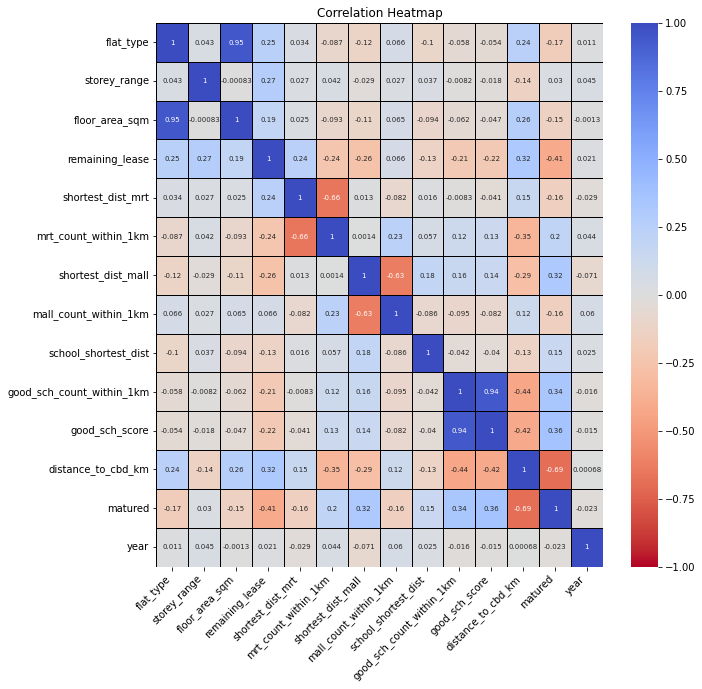

In [ ]:
#Check for collinearity
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(X.select_dtypes(include=['int64','float64']).corr(), annot = True, fmt='.2g', 
    vmin=-1, vmax=1, center= 0, cmap= 'coolwarm_r', linecolor='black', linewidth=1, annot_kws={"size": 7})
#ax.set_ylim(0 ,5)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap')
fig.show()


In [ ]:
# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['tolerance'] = 1/vif.VIF
    vif['mean'] = vif.VIF.mean()

    return(vif)

calc_vif(X.select_dtypes(include=['int64','float64']))

,features,VIF,tolerance,mean
0,flat_type,75.672617,0.013215,15.108213
1,storey_range,2.717736,0.367953,15.108213
2,floor_area_sqm,11.744713,0.085145,15.108213
3,remaining_lease,1.531905,0.652782,15.108213
4,shortest_dist_mrt,1.969460,0.507753,15.108213
5,mrt_count_within_1km,4.875317,0.205115,15.108213
6,shortest_dist_mall,1.955622,0.511346,15.108213
7,mall_count_within_1km,4.618289,0.216530,15.108213
8,school_shortest_dist,1.078623,0.927108,15.108213
9,good_sch_count_within_1km,13.019755,0.076806,15.108213


Since VIF score is still Rather High, we will drop some variables.

1) flat_type is highly correlated with floor_area_sqm. Since floor_area_sqm is more quantifiable, we will drop flat_type.

2) good_sch_score and good_sch_count_within_1km are highly correlated, we will remove the latter.

3) For the same reason, we will drop mall and mrt count within 1km.

4) Lastly drop matured as it is closely correlated to distance from CBD and the latter is more quantifiable

In [ ]:
lr_X = X.drop(['flat_type','good_sch_count_within_1km','mrt_count_within_1km','mall_count_within_1km','matured',], axis=1)
calc_vif(lr_X.select_dtypes(include=['int64','float64']))
#VIF is now significantly smaller

,features,VIF,tolerance,mean
0,storey_range,2.701373,0.370182,1.647184
1,floor_area_sqm,1.098602,0.910248,1.647184
2,remaining_lease,1.387407,0.720769,1.647184
3,shortest_dist_mrt,1.083835,0.922650,1.647184
4,shortest_dist_mall,1.161356,0.861063,1.647184
5,school_shortest_dist,1.067917,0.936402,1.647184
6,good_sch_score,1.702232,0.587464,1.647184
7,distance_to_cbd_km,1.543239,0.647988,1.647184
8,year,3.078696,0.324813,1.647184


In [ ]:
# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(lr_X,np.log(y),test_size=0.2,random_state=100)

lr = LinearRegression()
lin_reg_r2, lin_reg_mae = model_performance(lr)

lr_importance = pd.DataFrame(list(zip(X_train.columns, lr.coef_)), columns =['Features', 'Coeff'])
np.array(lr_importance.sort_values(by = 'Coeff', ascending = False))

R^2 score = 0.886713305075986
Test loss (MAE): 0.08335536735000039


array([['town_MARINE PARADE', 0.4162962351333529],
       ['town_BUKIT TIMAH', 0.31477109624205424],
       ['floor_area_sqm', 0.23820267546722218],
       ['flat_model_DBSS', 0.1752704270854328],
       ['remaining_lease', 0.13921495794971409],
       ['town_BISHAN', 0.13544056574670407],
       ['town_QUEENSTOWN', 0.12085722908727375],
       ['town_BUKIT MERAH', 0.07544734191000849],
       ['town_CLEMENTI', 0.07357975503690477],
       ['flat_model_Simplified', 0.06765400679395016],
       ['town_CENTRAL AREA', 0.061353486561176805],
       ['flat_model_New Generation', 0.050603376055255236],
       ['flat_model_Maisonette', 0.048615202668258674],
       ['town_BEDOK', 0.030853605198827364],
       ['town_SERANGOON', 0.027353664662047455],
       ['flat_model_Premium Apartment', 0.027313257083809883],
       ['storey_range', 0.024884211256068895],
       ['flat_model_Model A2', 0.02169239421752026],
       ['town_TOA PAYOH', 0.02070084849093327],
       ['flat_model_Standard', 0.01

2. Random Forest

In [ ]:
# Split target variable from dataset
X = df.drop('normalized_price', axis=1)
y = df['normalized_price']
y = y.reset_index(drop=True)

# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

rf = RandomForestRegressor()
rf_r2, rf_mae = model_performance(rf)

rf_importance = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)), columns =['Features', 'Coeff'])
rf_importance.sort_values(by = 'Coeff', ascending = False)


R^2 score = 0.9725108402926438
Test loss (MAE): 18095.229227307813


,Features,Coeff
2,floor_area_sqm,0.450420
11,distance_to_cbd_km,0.218887
3,remaining_lease,0.105601
0,flat_type,0.042233
1,storey_range,0.036357
12,matured,0.032873
13,year,0.026704
4,shortest_dist_mrt,0.022080
6,shortest_dist_mall,0.017429
8,school_shortest_dist,0.006888


3. XG Boost

In [ ]:
# Split target variable from dataset
X = df.drop('normalized_price', axis=1)
y = df['normalized_price']
y = y.reset_index(drop=True)

# Divide data into training set and test set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100)

xgb = XGBRegressor()
xgb_r2, xgb_mae = model_performance(xgb)

xgb_importance = pd.DataFrame(list(zip(X_train.columns, xgb.feature_importances_)), columns =['Features', 'Coeff'])
xgb_importance.sort_values(by = 'Coeff', ascending = False)


R^2 score = 0.9670685084439576
Test loss (MAE): 20363.81628501021


,Features,Coeff
12,matured,0.219448
0,flat_type,0.115942
2,floor_area_sqm,0.098125
44,flat_model_New Generation,0.076895
11,distance_to_cbd_km,0.064682
19,town_BUKIT TIMAH,0.039985
15,town_BISHAN,0.033126
28,town_MARINE PARADE,0.025318
3,remaining_lease,0.023068
39,flat_model_DBSS,0.022255
